In [1]:
# Data handling
import pandas as pd
import numpy as np

# Warnings
import warnings

# Model and evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.exceptions import UndefinedMetricWarning

# Utilities and plotting
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Ignore general user warnings (e.g., from seaborn, pandas)
warnings.filterwarnings("ignore", category=UserWarning)

# Ignore warnings for undefined metrics (e.g., F1 score when no positive predictions)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [3]:
# Load the dataset from Excel file
df = pd.read_excel('train.xlsx')

In [4]:
df.head()

,Unnamed: 0,NCBIGeneID,Symbol,Description,GeneType,GeneGroupMethod,NucleotideSequence
0,0,106481178,RNU4-21P,"RNA, U4 small nuclear 21, pseudogene",PSEUDO,NCBI Ortholog,<AGCTTAGCACAGTGGCAGTATCATAGGCAGTGAGGTTTATCCGAG...
1,1,123477792,LOC123477792,Sharpr-MPRA regulatory region 12926,BIOLOGICAL_REGION,NCBI Ortholog,<CTGGAGCGGCCACGATGTGAACTGTCACCGGCCACTGCTGCTCCG...
2,2,113174975,LOC113174975,Sharpr-MPRA regulatory region 7591,BIOLOGICAL_REGION,NCBI Ortholog,<TTCCCAATTTTTCCTCTGCTTTTTAATTTTCTAGTTTCCTTTTTC...
3,3,116216107,LOC116216107,CRISPRi-validated cis-regulatory element chr10...,BIOLOGICAL_REGION,NCBI Ortholog,<CGCCCAGGCTGGAGTGCAGTGGCGCCATCTCGGCTCACTGCAGGC...
4,4,28502,IGHD2-21,immunoglobulin heavy diversity 2-21,OTHER,NCBI Ortholog,<AGCATATTGTGGTGGTGACTGCTATTCC>


In [5]:
df.isnull().sum()

Unnamed: 0            0
NCBIGeneID            0
Symbol                0
Description           0
GeneType              0
GeneGroupMethod       0
NucleotideSequence    0
dtype: int64

In [6]:
df.describe()

,Unnamed: 0,NCBIGeneID
count,22593.000000,2.259300e+04
mean,9219.912318,9.133165e+07
std,5345.379611,4.328996e+07
min,0.000000,6.300000e+01
25%,4573.000000,1.002710e+08
50%,9239.000000,1.064802e+08
75%,13839.000000,1.210532e+08
max,19021.000000,1.249095e+08


In [7]:
# Extract sequences and labels from the DataFrame
sequences = df['NucleotideSequence']
labels = df['GeneType']

In [8]:
# Function to one-hot encode a nucleotide sequence with padding/truncation
def one_hot_encode_seq(seq, max_len=300):
    mapping = {
        'A': [1, 0, 0, 0],
        'C': [0, 1, 0, 0],
        'G': [0, 0, 1, 0],
        'T': [0, 0, 0, 1],
        'N': [0.25, 0.25, 0.25, 0.25]  # Unknown/ambiguous base
    }
    encoding = [mapping.get(char.upper(), [0, 0, 0, 0]) for char in seq]

    # Pad or truncate to max_len
    if len(encoding) > max_len:
        encoding = encoding[:max_len]
    else:
        while len(encoding) < max_len:
            encoding.append([0, 0, 0, 0])

    # Add normalized sequence length as a feature
    seq_len = min(len(seq), max_len) / max_len
    flattened = np.array(encoding).flatten().tolist()
    flattened.append(seq_len)
    return flattened

# Determine max sequence length (95th percentile for dynamic padding)
lengths = [len(seq) for seq in sequences]
max_len = int(np.percentile(lengths, 95))
print(f"\n Using max sequence length: {max_len} (95th percentile)")

# Encode all sequences in parallel for speed
from joblib import Parallel, delayed
X = np.array(Parallel(n_jobs=-1)(delayed(one_hot_encode_seq)(seq, max_len) for seq in sequences))



 Using max sequence length: 916 (95th percentile)


In [9]:
# Encode target labels to integers
le = LabelEncoder()
y = le.fit_transform(labels)

# Show distribution of encoded labels
print(f"\n Encoded label distribution: {Counter(y)}")


 Encoded label distribution: Counter({np.int64(3): 10220, np.int64(0): 6925, np.int64(4): 2497, np.int64(8): 1148, np.int64(2): 524, np.int64(9): 488, np.int64(1): 366, np.int64(5): 277, np.int64(7): 145, np.int64(6): 3})


In [10]:
# Split data into training and validation sets with stratified sampling
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Show computed class weights
print(f"\n Computed class weights: {class_weight_dict}")


 Computed class weights: {np.int64(0): np.float64(0.32624548736462095), np.int64(1): np.float64(6.168600682593857), np.int64(2): np.float64(4.313603818615752), np.int64(3): np.float64(0.22106164383561644), np.int64(4): np.float64(0.9046046046046046), np.int64(5): np.float64(8.141441441441442), np.int64(6): np.float64(903.7), np.int64(7): np.float64(15.581034482758621), np.int64(8): np.float64(1.9688453159041395), np.int64(9): np.float64(4.634358974358975)}


In [14]:
# Define and train the Random Forest model
def build_model(X_train, y_train):
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight=class_weight_dict,
        random_state=42,
        n_jobs=-1,
        bootstrap=True,
        oob_score=True,
        max_features='sqrt'
    )
    model.fit(X_train, y_train)
    return model


In [15]:
# Step 7: Evaluate Model
def evaluate_model(model, X_val, y_val, le):
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')
    
    print(f"\n Accuracy: {acc:.4f}")
    print(f" Weighted F1 Score: {f1:.4f}")
    
    print("\n Classification Report:")
    print(classification_report(y_val, y_pred, target_names=le.classes_, zero_division=1))


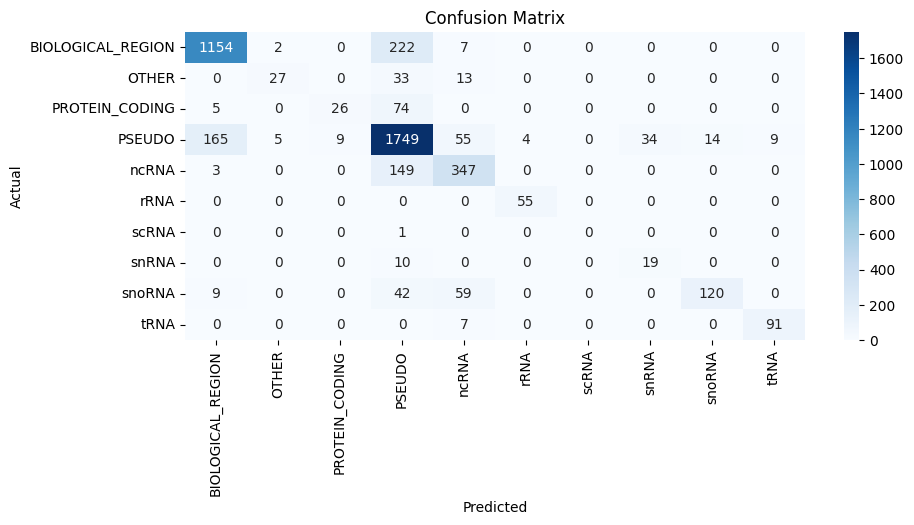

In [18]:
model = build_model(X_train, y_train)

y_pred = model.predict(X_val)

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

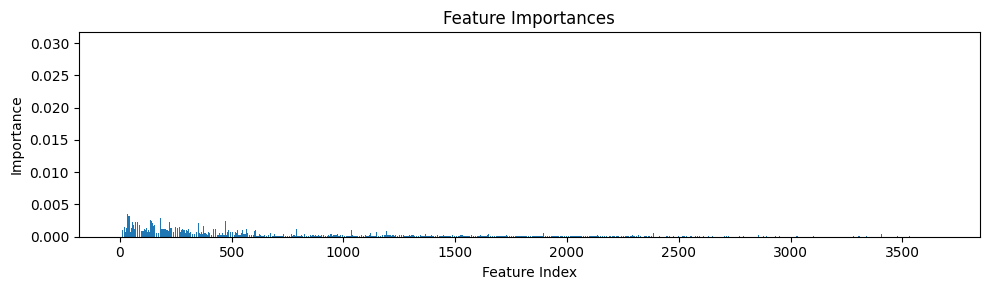

In [19]:
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    plt.figure(figsize=(10, 3))
    plt.bar(range(len(importances)), importances)
    plt.title('Feature Importances')
    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()


In [20]:
evaluate_model(model, X_val, y_val, le)  # Final evaluation on validation set


 Accuracy: 0.7940
 Weighted F1 Score: 0.7885

 Classification Report:
                   precision    recall  f1-score   support

BIOLOGICAL_REGION       0.86      0.83      0.85      1385
            OTHER       0.79      0.37      0.50        73
   PROTEIN_CODING       0.74      0.25      0.37       105
           PSEUDO       0.77      0.86      0.81      2044
            ncRNA       0.71      0.70      0.70       499
             rRNA       0.93      1.00      0.96        55
            scRNA       1.00      0.00      0.00         1
            snRNA       0.36      0.66      0.46        29
           snoRNA       0.90      0.52      0.66       230
             tRNA       0.91      0.93      0.92        98

         accuracy                           0.79      4519
        macro avg       0.80      0.61      0.62      4519
     weighted avg       0.80      0.79      0.79      4519



In [21]:
import joblib

joblib.dump(model, 'dna_classifier_rf.pkl')       # Save trained model
joblib.dump(le, 'label_encoder.pkl')              # Save label encoder
print("\n Model and label encoder saved to disk.")



 Model and label encoder saved to disk.
